# Download data and unzip! 

In [9]:
# download file and unzip! 
base_dir = "/local/ecw/redux_test"
data_path = "https://ochre.lib.uchicago.edu/deepscribe/deepscribe_2023_02_04_public.tar.gz"
!cd {base_dir} && pwd && wget {data_path} && tar -xzf deepscribe_2023_02_04_public.tar.gz

/local/ecw/redux_test
--2023-02-23 23:39:17--  https://ochre.lib.uchicago.edu/deepscribe/deepscribe_2023_02_04_public.tar.gz
Resolving ochre.lib.uchicago.edu (ochre.lib.uchicago.edu)... 128.135.181.16
Connecting to ochre.lib.uchicago.edu (ochre.lib.uchicago.edu)|128.135.181.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815401491 (778M) [application/x-gzip]
Saving to: ‘deepscribe_2023_02_04_public.tar.gz’

deepscribe_2023_02_ 100%[===================>] 777.63M  97.6MB/s    in 7.7s    

2023-02-23 23:39:25 (101 MB/s) - ‘deepscribe_2023_02_04_public.tar.gz’ saved [815401491/815401491]



In [12]:
output_dir = "/local/ecw/redux_test/DeepScribe_Data_2023-02-04_public"

In [13]:
!ls {output_dir}

categories.txt	images	imagesWithHotspots.json


In [14]:
# Example data files
import json
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image, write_jpeg
import torch
import torchvision.transforms.functional as F
from deepscribe2.utils import get_boxes

In [15]:
with open(output_dir + "/imagesWithHotspots.json") as inf:
    all_data = json.load(inf)

In [17]:
indx = 0
entry = all_data[0]
entry

{'text_id': 'd56bd565-2caa-49fe-350a-7cc43a01b2c3',
 'image_name': 'PF 0001 Lower Edge 1, conventional, annotated',
 'file_name': '6603e2b2-7146-066d-7bde-ef212e43e08c.jpg',
 'is_published': 'true',
 'width': 1800,
 'annotations': [{'category_id': 48,
   'sign_id': '06cfebac-88b0-4476-85e6-0205356deadb',
   'bbox': [288, 301, 644, 528],
   'sign': 'UL',
   'reading': 'ul',
   'epigraphicUnit_id': '585f0438-791a-d1d4-0bd6-b0fc61e107f1',
   'reading_id': 'bac23382-7178-b5c9-5b26-765f27ad4b8c'},
  {'category_id': 38,
   'sign_id': '19076780-7e11-8cfe-7c33-50d8eb66ac51',
   'bbox': [679, 271, 843, 544],
   'sign': 'U',
   'reading': 'U',
   'epigraphicUnit_id': 'c5610daa-0902-4592-65ed-55ffff1ea508',
   'reading_id': '3662545a-9649-4a74-ab00-6be3fe1916d7'},
  {'category_id': 43,
   'sign_id': '46ac73aa-f7da-1a09-412d-0beebebf0327',
   'bbox': [858, 265, 1055, 541],
   'sign': 'ÀŠ',
   'reading': 'ÀŠ',
   'epigraphicUnit_id': '9cc58730-1dcf-2c10-b3e2-14b1decd23e4',
   'reading_id': 'f6f5438

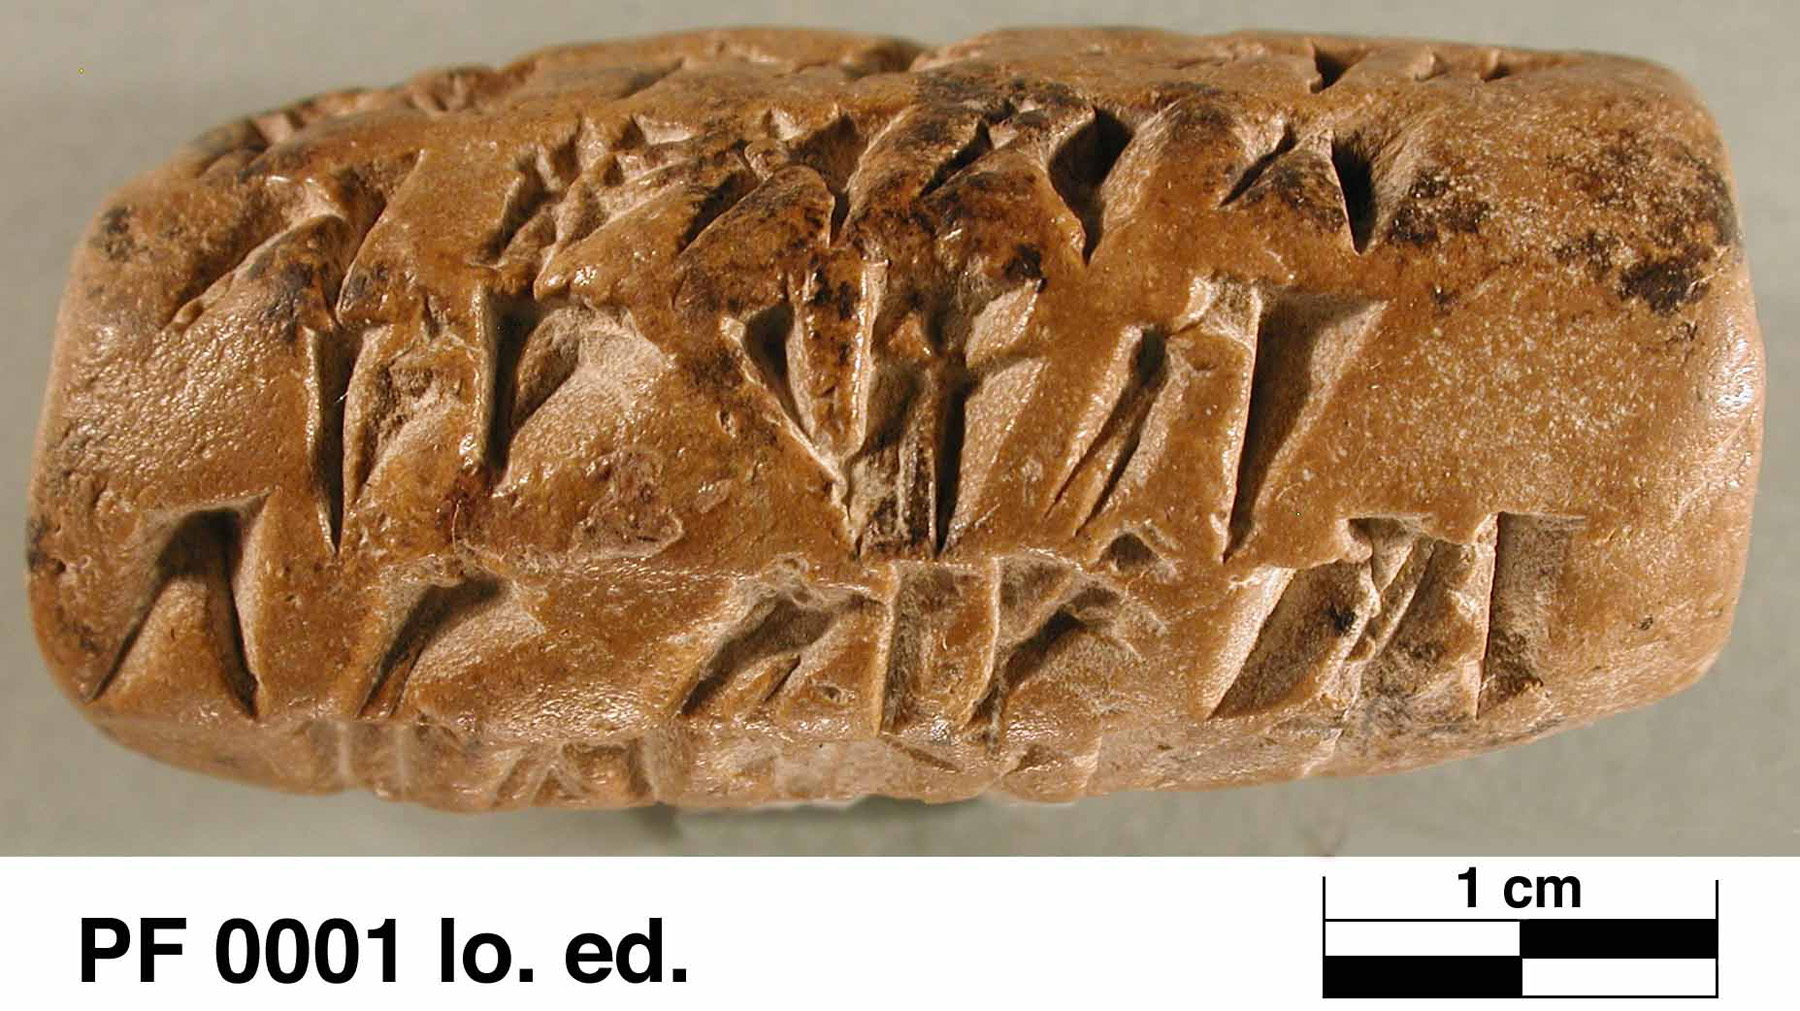

In [18]:
example_img = read_image(output_dir + "/images/" + entry["file_name"])
F.to_pil_image(example_img)

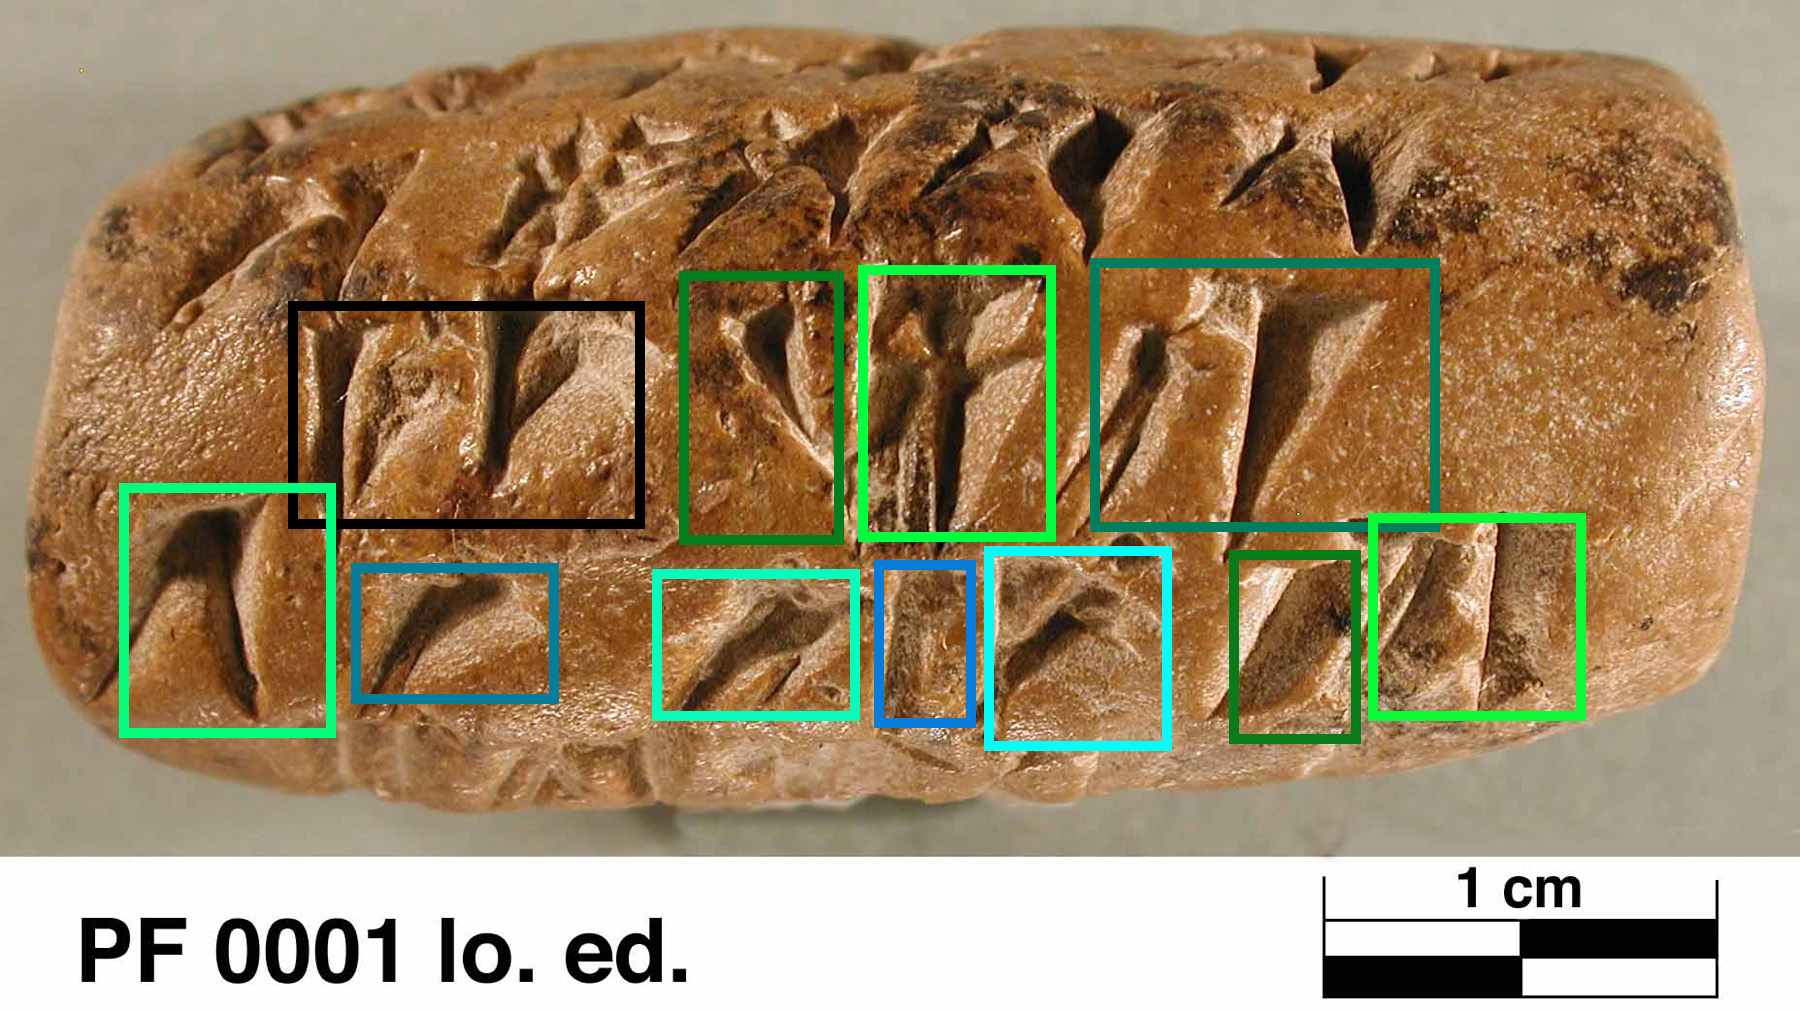

In [24]:
# now render the bounding boxes...
boxes = get_boxes(entry)
F.to_pil_image(draw_bounding_boxes(example_img, boxes, width=10))

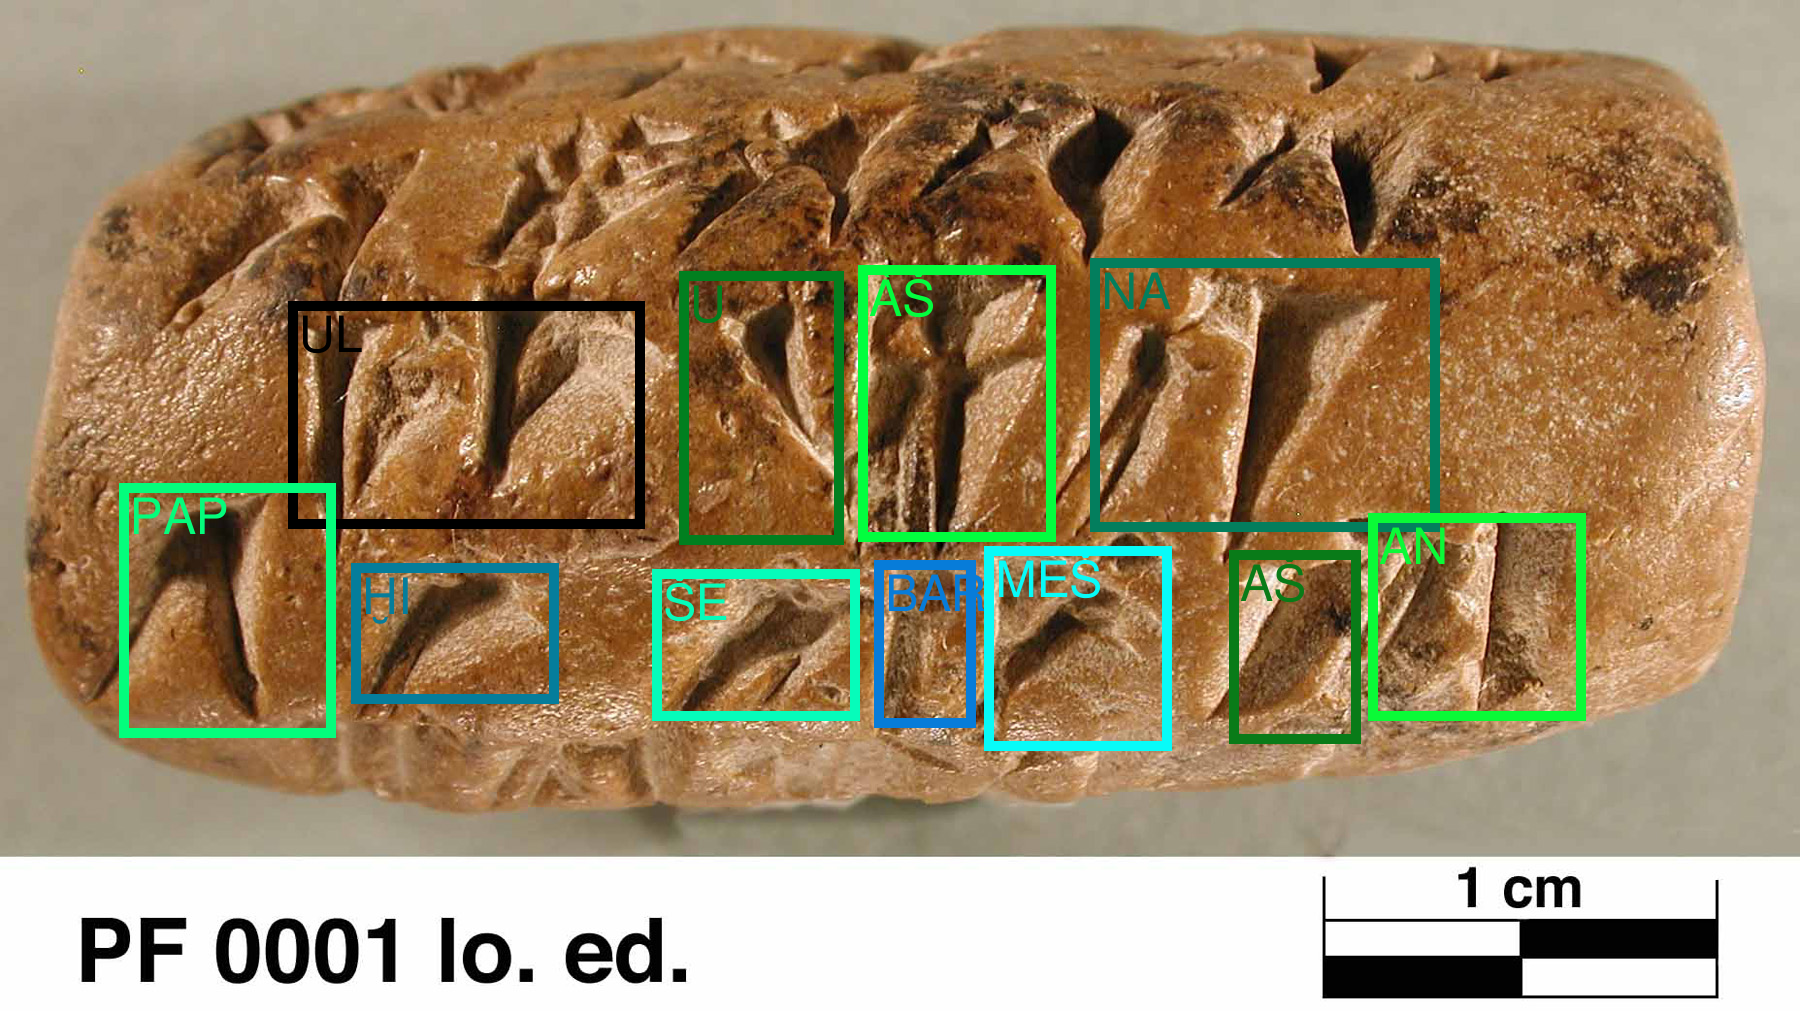

In [30]:
# draw sign classes
signs = [anno["sign"] for anno in entry["annotations"]]
boxes = get_boxes(entry)
F.to_pil_image(draw_bounding_boxes(example_img, 
                                   boxes, 
                                   width=10, 
                                   labels=signs,
                                   font="FreeSans.ttf",
                                  font_size=50))

# Object Detector Training

In [31]:
from pathlib import Path

import pytorch_lightning as pl

import wandb
from deepscribe2 import transforms as ds_transforms
from deepscribe2.datasets import PFADetectionDataModule
from deepscribe2.models import RetinaNet

In [32]:
# define data augmentation!
xforms = ds_transforms.Compose(
    [
        ds_transforms.RandomHorizontalFlip(),
        ds_transforms.RandomShortestSize(
            [500, 640, 672, 704, 736, 768, 800], 1333
        ),
    ]
)


In [33]:
pfa_data_module = PFADetectionDataModule(
    output_dir,
    autocrop=True, # this will trim images using the provided boxes. 
    batch_size=2,
    train_xforms=xforms,
    localization_only=True,
)


In [ ]:
model = RetinaNet(num_classes=1) # only training with localization. 

In [ ]:
# define callbacks.
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="map_50", mode="max"
)
earlystop_callback = pl.callbacks.EarlyStopping(
    monitor="map_50", mode="max", patience=20
)


In [ ]:
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    logger=logger,
    max_epochs=1000,
    callbacks=[checkpoint_callback, earlystop_callback],
)
trainer.fit(model, datamodule=pfa_data_module)


In [ ]:
# run inference with detector! 

# Train classifier! 


In [ ]:
from torchvision import transforms as T

from deepscribe2.datasets import PFAClassificationDataModule
from deepscribe2.models.classification import ImageClassifier

In [ ]:
train_xforms = [
    T.RandomAffine(0, translate=(0.2, 0.2)),
    T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    T.RandomPerspective(),
]

classification_datamodule = PFAClassificationDataModule(
    output_dir, batch_size=512, hotspot_size=(50, 50), train_xforms=train_xforms
)

In [ ]:
classification_model = ImageClassifier(classification_datamodule.num_labels)


In [ ]:
checkpoint_callback_cls = pl.callbacks.ModelCheckpoint(
    monitor="val_loss", mode="min"
)
earlystop_callback_cls = pl.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", patience=20
)


In [ ]:
trainer_cls = pl.Trainer(
    accelerator="gpu",
    devices=1,
    logger=logger,
    max_epochs=100,
    callbacks=[checkpoint_callback, earlystop_callback],
)
trainer.fit(classification_model, datamodule=classification_datamodule)

# inference with full pipeline! 

In [ ]:
from deepscribe2.pipeline import DeepScribePipeline

In [ ]:
pipeline = DeepScribePipeline(
    detection_ckpt,
    pfa_datamodule.categories_file,
    classifier_ckpt=classification_ckpt,
    score_thresh=0.5,
)

In [ ]:
pfa_datamodule.setup(stage="test")
test_img, test_targets = next(pfa_datamodule.test_dataloader())